# Mini-Lab: Logistic Regression and SVMs (Modeling)

__Team Members__
- Name 1: Jorge Olmos
- Name 2: Bosang Yun
- Name 3: Yucheol Shin
- Name 4: Siu Wai Yeung

# Content
* [Data Importing and Cleaning](#Data-Importing-and-Cleaning)
* [Select Modeling Techniques](#Select-Modeling-Techniques)
* [Generate Test Design](#Generate-Test-Design)
* [Build Model](#Build-Model)
* [Assess Model](#Assess-Model)


# Data Importing and Cleaning<a id='Data-Importing-and-Cleaning'/>

In [151]:
import pandas as pd
import numpy as np

hotel_bookings = pd.read_csv('https://raw.githubusercontent.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/main/hotel_bookings.csv') # read in the csv file
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/15


In [271]:
import math
from datetime import date


hotel_bookings_transform = hotel_bookings
hotel_bookings_transform= hotel_bookings_transform.drop(columns=['agent','company', 'country'])

hotel_bookings_transform['meal']= hotel_bookings_transform['meal'].apply(lambda x: 'SC' if  x == 'Undefined'  else x)
hotel_bookings_transform['children']= hotel_bookings_transform['children'].apply(lambda x: 0 if  math.isnan(x)  else x)
hotel_bookings_transform['market_segment']= hotel_bookings_transform['market_segment'].apply(lambda x: 'Online TA' if  x == 'Undefined'  else x)
hotel_bookings_transform['distribution_channel']= hotel_bookings_transform['distribution_channel'].apply(lambda x: 'TA/TO' if  x == 'Undefined'  else x)


hotel_bookings_transform['hotel']=hotel_bookings_transform['hotel'].astype('category').cat.codes
hotel_bookings_transform['market_segment']=hotel_bookings_transform['market_segment'].astype('category').cat.codes
hotel_bookings_transform['meal']=hotel_bookings_transform['meal'].astype('category').cat.codes
hotel_bookings_transform['reservation_status']=hotel_bookings_transform['reservation_status'].astype('category').cat.codes
hotel_bookings_transform['distribution_channel']=hotel_bookings_transform['distribution_channel'].astype('category').cat.codes
hotel_bookings_transform['reserved_room_type']=hotel_bookings_transform['reserved_room_type'].astype('category').cat.codes
hotel_bookings_transform['assigned_room_type']=hotel_bookings_transform['assigned_room_type'].astype('category').cat.codes
hotel_bookings_transform['deposit_type']=hotel_bookings_transform['deposit_type'].astype('category').cat.codes
hotel_bookings_transform['customer_type']=hotel_bookings_transform['customer_type'].astype('category').cat.codes

assign_month = {"arrival_date_month": {"January": 1, "February": 2, "March": 3, "April": 4,"May": 5,"June": 6,"July": 7,"August": 8,"September": 9,"October": 10,"November": 11,"December": 12}}
hotel_bookings_transform = hotel_bookings_transform.replace(assign_month)

# Convert Date to Ordinal
import datetime as dt
hotel_bookings_transform['reservation_status_date'] = pd.to_datetime(hotel_bookings_transform['reservation_status_date'])
hotel_bookings_transform['reservation_status_date'] = hotel_bookings_transform['reservation_status_date'].map(dt.datetime.toordinal)

hotel_bookings_transform=hotel_bookings_transform.assign(booking_day_of_year = hotel_bookings_transform["arrival_date_year"].astype(str) + '-' + 
hotel_bookings_transform["arrival_date_month"].astype(str) + '-' +hotel_bookings_transform["arrival_date_day_of_month"].astype(str))
hotel_bookings_transform['booking_day_of_year']=pd.to_datetime(hotel_bookings_transform.booking_day_of_year)
hotel_bookings_transform['booking_day_of_year']=hotel_bookings_transform['booking_day_of_year'].map(lambda x: x.toordinal() - date(x.year, 1, 1).toordinal() + 1)


hotel_bookings_transform=hotel_bookings_transform.drop(columns=['arrival_date_year','reservation_status_date'])
#hotel_bookings_transform['booking_date']=hotel_bookings_transform['booking_date'].map(dt.datetime.toordinal)

# Select Modeling Techniques<a id='Select-Modeling-Techniques'/>

# Generate Test Design: <a id='Generate-Test-Design'/>

## Normalization

- SVM tries to maximize the distance between the support vectors and the separating plane. 
- Prior to conducting SVM, we need to normalize the dataset so we can get rid of bias and dominance of certain features over others. 
- The result of applying normalized dataset will be having the same influence on the distance metric, thus boosting the accuracy of the model. 

In [272]:
X=hotel_bookings_transform.drop(columns=['is_canceled','reservation_status','meal'])
y=hotel_bookings_transform.is_canceled
columns = X.columns

In [273]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
scaler

scaler.mean_
scaler.scale_

X_scaled = pd.DataFrame(scaler.transform(X),columns=columns)

Verifying each feature has a mean of zero:

In [274]:
X_scaled.mean(axis=0)

hotel                            -2.148285e-13
lead_time                         3.358325e-16
arrival_date_month               -1.221612e-14
arrival_date_week_number          4.093983e-15
arrival_date_day_of_month        -9.159196e-16
stays_in_weekend_nights           3.928971e-14
stays_in_week_nights             -2.182022e-14
adults                            5.708995e-15
children                         -6.989886e-16
babies                            5.955017e-15
market_segment                    4.484909e-15
distribution_channel              2.185129e-14
is_repeated_guest                -3.493540e-14
previous_cancellations            1.741766e-14
previous_bookings_not_canceled   -1.286381e-15
reserved_room_type                1.246924e-13
assigned_room_type                9.462049e-14
booking_changes                  -7.015186e-14
deposit_type                      1.754553e-13
days_in_waiting_list             -1.846956e-14
customer_type                    -2.170149e-14
adr          

Verifying that the standard deviation should be 1:

In [275]:
X_scaled.std(axis=0)

hotel                             1.000004
lead_time                         1.000004
arrival_date_month                1.000004
arrival_date_week_number          1.000004
arrival_date_day_of_month         1.000004
stays_in_weekend_nights           1.000004
stays_in_week_nights              1.000004
adults                            1.000004
children                          1.000004
babies                            1.000004
market_segment                    1.000004
distribution_channel              1.000004
is_repeated_guest                 1.000004
previous_cancellations            1.000004
previous_bookings_not_canceled    1.000004
reserved_room_type                1.000004
assigned_room_type                1.000004
booking_changes                   1.000004
deposit_type                      1.000004
days_in_waiting_list              1.000004
customer_type                     1.000004
adr                               1.000004
required_car_parking_spaces       1.000004
total_of_sp

## Feature Selection 

Running initial model to select best parameters to be used for RFE selection:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

#cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2,random_state=10)

regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [10]
              ,'solver': ['lbfgs']
              ,'max_iter':[500,1000]
             }


from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , scoring='accuracy')

regGridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:   52.0s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [500, 1000], 'penalty': ['l2'],
                         'random_state': [10], 'solver': ['lbfgs']},
             scoring='accuracy', verbose=1)

### RFE Selection

In [8]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#for loop
rfecv = RFECV(estimator=classifierEst, step=1, scoring='accuracy')
rfecv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RFECV(estimator=LogisticRegression(C=1000, class_weight='balanced',
                                   max_iter=500, random_state=10),
      scoring='accuracy')

Here we're examining the plot of the categorical values of interest and looking at the optimal number of features:

Optimal number of features : 14


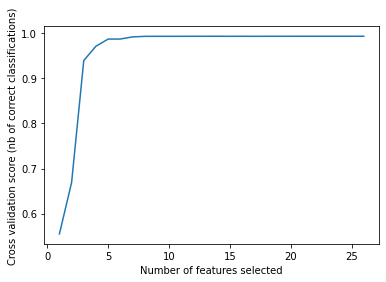

In [9]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [265]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_scaled.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top_features = rfe_ft_imp_df.head(50)

top_features

ValueError: arrays must all be same length

### Embedded method for feature selection
- 26 features are selected based on the weight distribution from the Recurvesive features selection result. 
- Embedded method is utilized to reduce the number of features further down with Lasso regularization method.
- LASSO regularization method penalizes coefficients of features and remove those that are with coefficient=0.
- A total of 7 features are selected : 
    - 'adr'
    - 'total_of_special_requests'
    - 'deposit_type'
    - 'booking_changes'
    - 'distribution_channel'
    - 'assigned_room_type'
    - 'market_segment'

In [277]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_sel, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_sel,y))
coef = pd.Series(reg.coef_, index = X_sel.columns)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.90659589695133, tolerance: 2.1639201430186996
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.35132674051965, tolerance: 2.1639201430186996
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.42640650375324, tolerance: 2.1639201430186996
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.558551579959385, tolerance: 2.37457557165593
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.50823672259503, tolerance: 2.37457557165593
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.33793961267475, tolerance: 2.37457557165593
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: Conv

Best alpha using built-in LassoCV: 0.056059
Best score using built-in LassoCV: 0.232606


In [278]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 19 variables


arrival_date_week_number          0.000000
previous_bookings_not_canceled    0.000456
babies                            0.001114
hotel                             0.002556
is_repeated_guest                 0.005881
adults                            0.008224
days_in_waiting_list              0.009489
children                          0.010883
stays_in_week_nights              0.012384
distribution_channel              0.015333
previous_cancellations            0.015368
customer_type                     0.017552
stays_in_weekend_nights           0.018429
booking_changes                   0.020296
adr                               0.024981
arrival_date_day_of_month         0.032619
required_car_parking_spaces       0.049854
total_of_special_requests         0.052599
lead_time                         0.058274
market_segment                    0.058585
reserved_room_type                0.060169
assigned_room_type                0.073992
deposit_type                      0.103741
arrival_dat

Text(0.5, 1.0, 'Feature importance using Lasso Model')

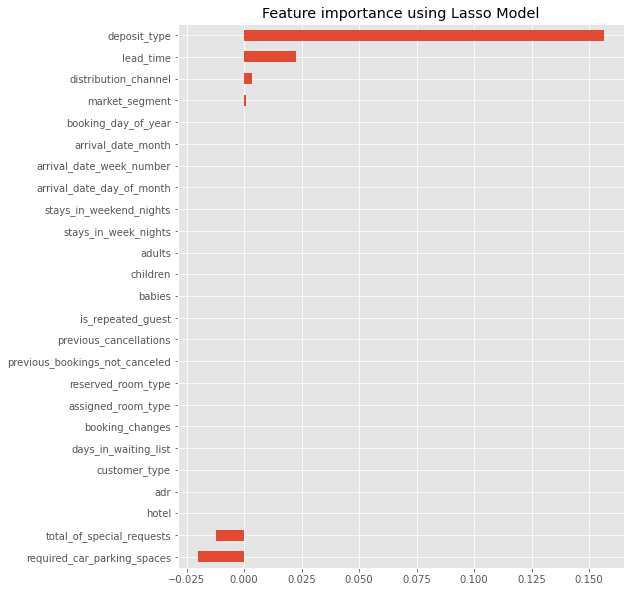

In [279]:
# Visualizing the feature importance using LASSO 

import matplotlib.pyplot as plt
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Text(0.5, 1.0, 'Feature importance using Lasso Model')

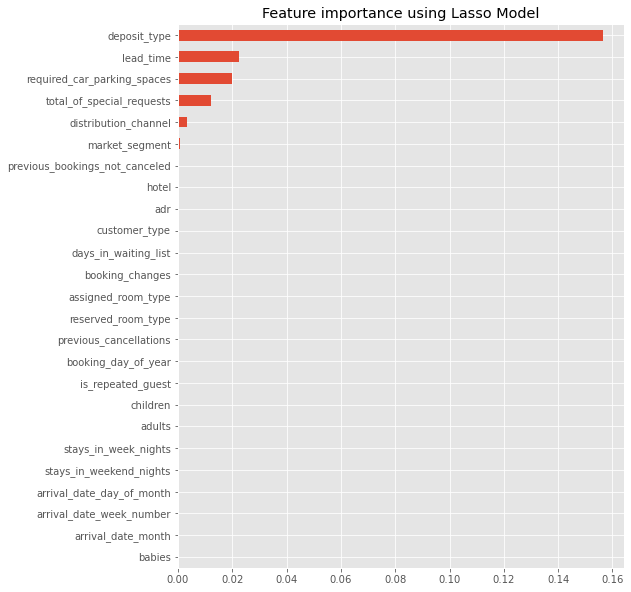

In [280]:
imp_coef = coef.sort_values()
abs_imp_coef = abs(imp_coef)
abs_imp_coef=abs_imp_coef.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
abs_imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")



## Cross Validation
- We applied the feature selection from above and decided to use 80:20 training/test split along with using gridSearch. 
- We will be using gridSearch function, which has 5 fold cross validation. 

In [342]:
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

# X_sel = X_scaled[[
# 'arrival_date_month',
# 'deposit_type',
# 'assigned_room_type',
# 'reserved_room_type',
# 'market_segment',
# 'lead_time',
# 'total_of_special_requests'
# ]]


X_sel = X_scaled[[
'deposit_type',
'lead_time',
'market_segment',
'distribution_channel',
'total_of_special_requests',
'required_car_parking_spaces',
'previous_bookings_not_canceled',
'adr'
]]

X_train, X_test, y_train, y_test = train_test_split(X_sel, y,test_size=0.2,random_state=10)

# Build Model<a id='Build-Model'/>

To build our model, after analyzing our feature selection we decided to keep all features that had weights greater than .9

### Model Comparision
 - Logistic regression 
	- Advantage
		- Performs well when data is linearly separable. 
		- Provides model coefficients as indicators of feature importance. 
		
	- Disadvantages
		- Limited only to linear boundary
		- Bounded by the assumption of linearity between dependent features and independent features. 

 - SVM
	- Advantages
		- Provides good accuracy
		- Uses less memory. 
		- Offers clear margin of separation. 
	- Disadvantages 
		- Not ideal for large dataset due to high training time. 
        - Works poorly with highly correlated features and is very sensitive to the type of kernel used

## Logistic Regression 


#### Adjust Parameter
- We used GridSearchCV to provide various parameters to adjust the model. GridSearchCV will run multiple computation to find the estimator with the best parameters that result the highest accuracy based on the scoring metric we provide.
- For penalization, we set penalty param for l1 and l2.
- For regularization, logistic regression has C parameter which is inversion of regularization. We provide C from 0.001 to 1000. Then we also 
- For class weight, we used balanced and none. Balanced mode uses value of target to adjust weights inversely proportional to the class frequencies. 
- For solver param, which is algorithm to used in optimization problem, we used lbfgs which is default and saga which is good fit for the large data set.

### Why do you think some variables are more important?

Doing f1 scoring, which is best for a binary target like is_canceled

In [343]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
regEstimator = LogisticRegression()


tuning_parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [10] 
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }


#Doing f1 for accuracy best for binary

#Create a grid search object using the  

from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuning_parameters
                   , scoring='f1')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_train, y_train)

means = regGridSearch.cv_results_['mean_test_score']
stds = regGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, regGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 125 out of 140 | elapsed:    5.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    5.5s finished


              precision    recall  f1-score   support

           0       0.80      0.79      0.80     15017
           1       0.66      0.67      0.67      8861

    accuracy                           0.75     23878
   macro avg       0.73      0.73      0.73     23878
weighted avg       0.75      0.75      0.75     23878



In [193]:
 regGridSearch.best_params_

{'C': 0.01,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l2',
 'random_state': 10,
 'solver': 'lbfgs'}

In [194]:
regGridSearch.best_score_

0.6624542355547014

In [21]:
 regGridSearch.best_estimator_.intercept_

array([0.04961982])

In [22]:
regGridSearch.best_estimator_.coef_

array([[ 0.30411286, -0.48152853,  1.36906802, -0.28090374, -0.18092419,
        -0.21768211,  0.60451423,  0.41206531]])

In [ ]:
log_coefficients = pd.concat([pd.DataFrame(X_test.columns),pd.DataFrame(np.transpose(regGridSearch.best_estimator_.coef_))], axis = 1)
log_coefficients

## Support Vector Machines

### Adjust Parameter
 - Parameters for Non-linear SVM are Gamma(controls the size of the radial basis function kernel) and C(margin hardness).
 - The algorithm allows the margin to be flexible in terms of  allowing some support vectors creep into the margin based on the tuned parameter C(margin hardness). 
 - Gamma defines how far the influence of a single training example reaches. For example, for a high gamma value, a group of points near the boundary will have a higher weight and thus result in curvy boundary

### Do the chosen support vectors provide any insight into the data?

### Downsampling data
- We decided to downsample our data (10% of the original data) due to computational issue

In [344]:

X_downsample = X_sel


X_downsample.loc[:,'target'] = y

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [353]:
X_sample=X_downsample.sample(frac=0.02, replace=False, random_state=10)
y_sample=X_sample.target
X_sample.drop("target",axis=1,inplace=True)

In [354]:
from sklearn.model_selection import train_test_split
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample,test_size=0.2,random_state=10)

In [355]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score


svm_estimator = SVC()


tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [100]}]


svmGridSearch = GridSearchCV(estimator=svm_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

svmGridSearch.fit(X_sample_train, y_sample_train)

means = svmGridSearch.cv_results_['mean_test_score']
stds = svmGridSearch.cv_results_['std_test_score']


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  45 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:   14.7s finished


In [357]:
y_true, y_pred = y_sample_test, svmGridSearch.predict(X_sample_test)
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.99      0.83       305
           1       0.96      0.32      0.48       173

    accuracy                           0.75       478
   macro avg       0.84      0.66      0.66       478
weighted avg       0.81      0.75      0.71       478



In [362]:
X_sample_train

,deposit_type,lead_time,market_segment,distribution_channel,total_of_special_requests,required_car_parking_spaces,previous_bookings_not_canceled,adr
26209,-0.373175,-0.767447,0.846227,0.456981,-0.720694,-0.254873,-0.091555,1.108900
41138,-0.373175,-0.954603,0.846227,0.456981,-0.720694,-0.254873,-0.091555,-0.530935
32218,-0.373175,-0.599006,-0.732679,-1.746798,-0.720694,-0.254873,-0.091555,-0.926696
71445,-0.373175,1.974390,0.846227,0.456981,0.540666,-0.254873,-0.091555,0.033024
67156,-0.373175,-0.730016,0.846227,0.456981,0.540666,-0.254873,-0.091555,0.260586
...,...,...,...,...,...,...,...,...
53730,-0.373175,0.355490,0.846227,0.456981,-0.720694,-0.254873,-0.091555,-0.323161
66597,2.614780,2.704299,0.056774,0.456981,-0.720694,-0.254873,-0.091555,-0.431995
36171,-0.373175,1.852739,-0.732679,-1.746798,-0.720694,-0.254873,-0.091555,-2.015038
76972,2.614780,2.227051,-0.732679,0.456981,-0.720694,-0.254873,-0.091555,1.348928


In [358]:
# Support vector positions

len(svmGridSearch.best_estimator_.support_vectors_)

973

### Do the chosen support vectors provide any insight into the data?

- The goal of SVM is to find the hyperplane in which the margin is maximized between the separated dataset. 
- Support vectors are the points closest to the hyperplane and gives us 
- The support vectors we found from this lab suggests that _______

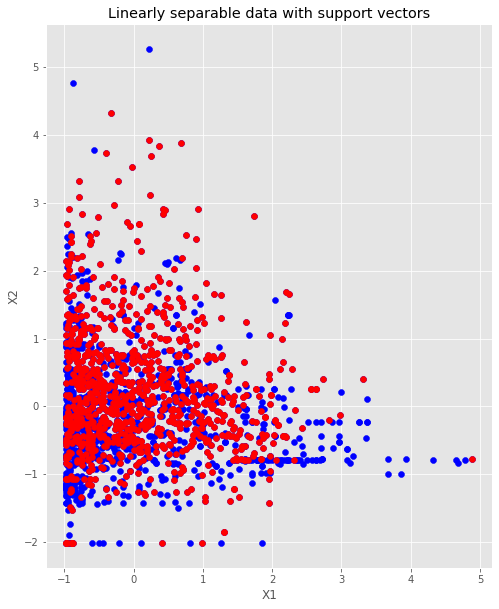

In [367]:
support_vectors = svmGridSearch.best_estimator_.support_vectors_

# Visualize support vectors
plt.scatter(X_sample_train['lead_time'], X_sample_train['adr'], color='blue')
plt.scatter(support_vectors[:,1], support_vectors[:,7], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [368]:
def plot_svc_decision_function(svmGridSearch, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [369]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(msvmGridSearch);

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [370]:
from sklearn.metrics import classification_report



tuned_parameters =  [{
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1],
    'random_state':[10]
}]



log_estimator = SGDClassifier()

logGridSearch = GridSearchCV(estimator=log_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

logGridSearch.fit(X_train, y_train)

means = logGridSearch.cv_results_['mean_test_score']
stds = logGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, logGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.3s finished


              precision    recall  f1-score   support

           0       0.77      0.93      0.84     15017
           1       0.82      0.52      0.64      8861

    accuracy                           0.78     23878
   macro avg       0.79      0.73      0.74     23878
weighted avg       0.79      0.78      0.77     23878



In [170]:
 logGridSearch.best_params_

{'alpha': 0.0001,
 'loss': 'log',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 10}

In [371]:
from sklearn.metrics import classification_report



tuned_parameters =  [{
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['hinge'], # svm,
    'penalty': ['l2'],
    'n_jobs': [-1],
    'random_state':[10]
}]



svm_estimator = SGDClassifier()

svmGridSearch = GridSearchCV(estimator=svm_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

svmGridSearch.fit(X_train, y_train)

means = svmGridSearch.cv_results_['mean_test_score']
stds = svmGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, svmGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.4s finished


              precision    recall  f1-score   support

           0       0.72      1.00      0.83     15017
           1       0.99      0.33      0.50      8861

    accuracy                           0.75     23878
   macro avg       0.85      0.67      0.67     23878
weighted avg       0.82      0.75      0.71     23878



In [178]:
 svmGridSearch.best_params_

{'alpha': 0.0001,
 'loss': 'hinge',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 10}

In [179]:
 svmGridSearch.best_estimator_

SGDClassifier(n_jobs=-1, random_state=10)

In [181]:
svmGridSearch.best_estimator_.coef_

array([[-3.56305517e-03,  2.36707960e-02,  6.59604562e-03,
        -3.12169054e-02, -5.76158594e-02, -6.36507896e-02,
         7.64737169e-01, -1.16667405e-02, -8.44919388e-01,
        -3.42802603e-02, -5.91503930e-02,  1.30220214e-01,
        -1.60096259e-03,  4.86489129e-03,  1.74892981e+00,
         2.77110871e-02,  7.72042263e-02,  6.51285659e-02,
         1.45241329e-02]])

# Assess Model<a id='Assess-Model'/>

### Does one type of model offer superior performance over another in terms of prediction accuracy? 
- We used SDG Classifier, stochastic gradient descent, and LogisticRegression classifiers to predict. SDG Classifier with logistic regression had prediction with the highest accuracy, 0.77, while SDG Classifier with SVM and LogisticRegression had 0.75 accuracy. Although we used both logistic for loss function, SDG Classifier had better accuracy than LogisticRegression model.

### In terms of training time or efficiency?

#### Logistic regression 
- It took about 11.1 seconds to process the data with LogisticRegression Classifier.

#### Linear SVM
- It took one hour for the gridSearch CV for the linear SVM to process the data. 

#### Stochastic Gradient Descent
- It took about 3.2 seconds to process the data with logistic regression loss function
- It took about 2.4 seconds to process the data with linear SVM loss function

### Best Model for efficiency and Accuracy
- For both Computation performance and Accuracy, **SDG Classifier with logistic regression** had better results.